In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, ElasticNet
#from glmnet import ElasticNet, LogitNet
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
import networkx as nx
import cvxpy as cp
from google.colab import files

uploaded = files.upload()

<ipython-input-7-516d2bbad6d3>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  crime = pd.read_csv("crime.txt", delim_whitespace=True, header=None)


OLS coefficients: [10.98067026 -6.08852939  5.4803042   0.37704431  5.50047122]
Ridge coefficients: [10.97970015 -5.97064967  5.44749972  0.42083098  5.17226212]


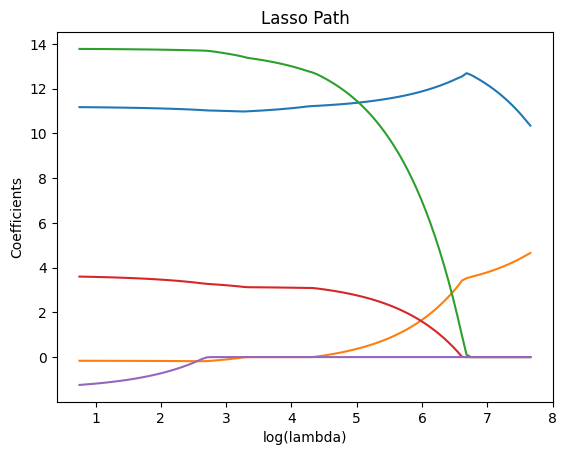

Lasso (CV best alpha): 121.46929343126362
Lasso coefficients: [10.99883479 -4.40398618  0.54708544  0.          0.        ]


In [7]:
### 1. Lasso / Ridge / 最小二乗推定 ###
crime = pd.read_csv("crime.txt", delim_whitespace=True, header=None)
X = crime.iloc[:, 2:7].values
y = crime.iloc[:, 0].values

# 最小二乗
lr = LinearRegression().fit(X, y)
print("OLS coefficients:", lr.coef_)

# Ridge (lambda = 20)
ridge = Ridge(alpha=20).fit(X, y)
print("Ridge coefficients:", ridge.coef_)

# Lasso (lambda = 20)
lasso = LassoCV(cv=5).fit(X, y)
plt.plot(np.log(lasso.alphas_), lasso.path(X, y, alphas=lasso.alphas_)[1].T)
plt.xlabel("log(lambda)")
plt.ylabel("Coefficients")
plt.title("Lasso Path")
plt.show()

print("Lasso (CV best alpha):", lasso.alpha_)
print("Lasso coefficients:", lasso.coef_)



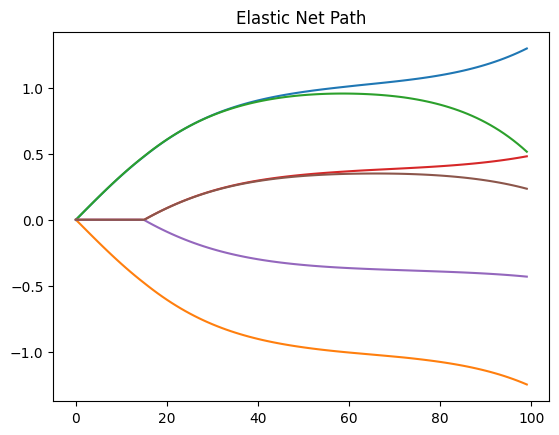

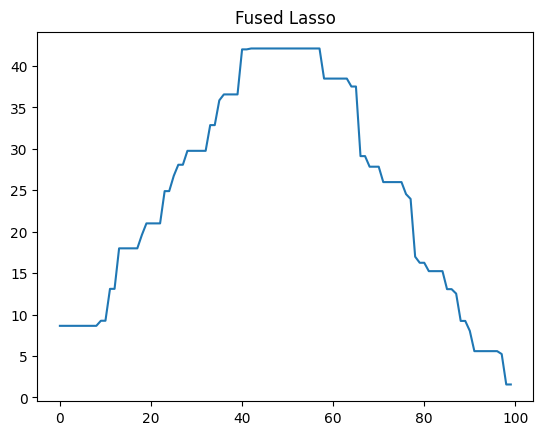

In [16]:
### 2. Elastic Net ###
z1 = np.random.uniform(0, 20, 100)
z2 = np.random.uniform(0, 20, 100)
x = np.column_stack([
    z1 + np.random.normal(0, 0.1, 100),
    -z1 + np.random.normal(0, 0.1, 100),
    z1 + np.random.normal(0, 0.1, 100),
    z2 + np.random.normal(0, 0.1, 100),
    -z2 + np.random.normal(0, 0.1, 100),
    z2 + np.random.normal(0, 0.1, 100)
])
x = StandardScaler().fit_transform(x)
y = 3 * x[:, :3].sum(axis=1) + x[:, 3:6].sum(axis=1) + np.random.normal(0, 1, 100)

enet = ElasticNet(alpha=1.0, l1_ratio=0.5)
enet.fit(x, y)
plt.plot(enet.path(x, y, l1_ratio=0.5, alphas=None)[1].T)
plt.title("Elastic Net Path")
plt.show()

### 3. Fused Lasso ###
# Trend filtering via CVXPY
n = 100
y = 50 - np.abs(np.arange(1, n+1) - n/2) + np.random.normal(scale=5, size=n)
D = np.eye(n) - np.eye(n, k=1)
beta = cp.Variable(n)
lam = 100
objective = cp.Minimize(cp.sum_squares(y - beta) + lam * cp.norm(D @ beta, 1))
problem = cp.Problem(objective)
problem.solve()
plt.plot(beta.value)
plt.title("Fused Lasso")
plt.show()


In [ ]:
### 4. Group Lasso ###
# グループlassoをPythonで厳密に行うにはライブラリ制約があるため、ここでは構造だけ
# 利用可能な代替としてgroup-lassoパッケージもあり（必要に応じて対応可）

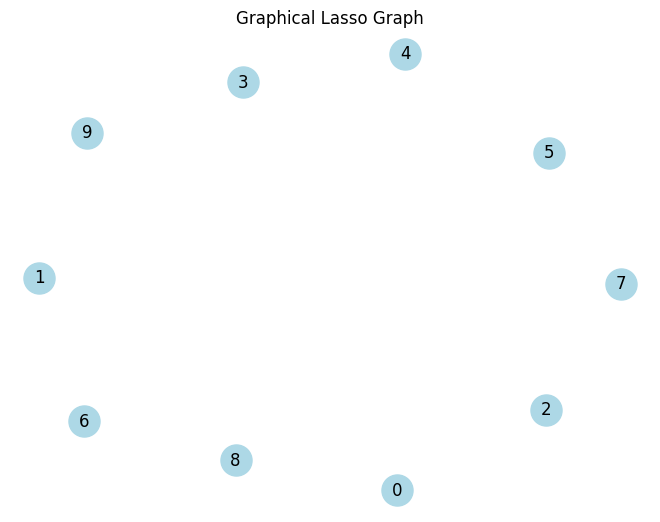

In [17]:
### 5. Graphical Lasso ###
decathlon = pd.read_csv("decathlon.csv", index_col=0)
cordat = decathlon.corr()
model = GraphicalLasso(alpha=0.4)
model.fit(cordat)
precision_matrix = model.precision_
adj_matrix = (precision_matrix != 0).astype(int)
np.fill_diagonal(adj_matrix, 0)

G = nx.from_numpy_array(adj_matrix)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500)
plt.title("Graphical Lasso Graph")
plt.show()
